In [45]:
# !pip install ntlk
# import re
# # import nltk
# # from nltk.tokenize import word_tokenize
# import pandas as pd
# import os
# import librosa as lbs
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sbn
# !pip install pydub
from pydub import AudioSegment

In [47]:
# A. Data Load
# Load the dataset as CSV file 
df = pd.read_csv('D:/CommonVoice/cv12.csv')

In [ ]:
# B. Preprocessing STT

In [54]:
# Check for NA rows in sentence(transcription)
empty = df.isna().sum()
print(f'Number of NA rows: {empty}')
df['sentence'].dropna() #Drop row with missing sentence 
# print(empty)

client_id          0
path               0
sentence           1
up_votes           0
down_votes         0
age            85478
gender         84210
accents       205390
locale             0
segment       205390
duration           0
tokens             0
dtype: int64


In [ ]:
# If we do not need columns with fully Na rows(accents) we can drop column
# df = df.drop('accents', axis=1)

In [ ]:
# Check for duplicate rows
duplicates = df.duplicated()
print(f'Number of duplicated rows: {duplicates.sum()}')
df.drop_duplicates()

In [ ]:
#Know if dataset have the same values(can we change to categorical or other data types)
print(df['age'].value_counts())
print(df['gender'].value_counts())# Gender more fitting to transform into categ types: male- 0, female- 1, other -2
df['gender'] = data['gender'].apply({'male':0, 'female':1, 'other':2}.get)

In [48]:
# df = df.drop('tokens', axis=1)
#Tokenize and clean sentence column and save as new column
def tokenize(word):
    if isinstance(word, str):  
        word = word.lower()  
        tokens = re.findall(r'\b\w+\b', word)
        return tokens
    else:
        return [] 
df['tokens'] = df['sentence'].apply(tokenize)

In [49]:
# Count how many files have more than 15 seconds 
count = (df['duration'] > 15).sum()
print(count)

26


In [ ]:
# Segmentation audio files which are more than 15 seonds
audioFilePath = 'D:/cache'
file_path = os.path.join(audioFilePath, path)

def segment_audio(file_path, segment_length_ms=15000):
    audio = AudioSegment.from_file(file_path) 
    segments = []
    
    if len(audio) > segment_length_ms:  # Only segment if audio is longer than 15 seconds
        for i in range(0, len(audio), segment_length_ms):
            segment = audio[i:i + segment_length_ms]
            segments.append(segment)
    
    return segments

# New column for duration of segment(we have empty column "segment" in df)
df['duration_segment'] = None

for index, row in df.iterrows():
    file_path = os.path.join(audioFilePath, row['path'])  
    duration = row['duration']
    
    if duration > 15:  # Check if duration is greater than 15 seconds
        try:
            segments = segment_audio(file_path)  # Get segments
        except:
           break  

        
        # Iterate over the segments and save each one
        for i, segment in enumerate(segments):
            # Create a segment filename with the original file name
            segment_file_name = f"D:/cache/{os.path.splitext(row['path'])[0]}_segment_{i}.mp3"
            segment.export(segment_file_name, format="mp3")
            
            # Save segment path and its duration in the DataFrame
            df.at[index, 'segment'] = segment_file_name  # Save segment path
            df.at[index, 'duration_segment'] = len(segment) / 1000  # Save duration in seconds
            print(f"Segment saved: {segment_file_name} with duration: {len(segment) / 1000} seconds")


print(df)



In [ ]:
audioFilePath = 'D:/cache'

def resample_audio(file_path, target_sample_rate=16000):  # usual sample_rate for STT
    audio = AudioSegment.from_file(file_path)  

    if audio.frame_rate != target_sample_rate:
        audio = audio.set_frame_rate(target_sample_rate)
    
    return audio

# New column for resampled audio
df['resampled'] = None

for index, row in df.iterrows():
    file_path = os.path.join(audioFilePath, row['path']) 
    
    try:
    
        resampled_audio = resample_audio(file_path)
        resampled_file_name = f"D:/cache/{os.path.splitext(row['path'])[0]}_resampled.mp3"
        resampled_audio.export(resampled_file_name, format='mp3')
        
        # Save the path of the resampled audio
        df.at[index, 'resampled'] = resampled_file_name
        
        print(f"Resampled audio saved: {resampled_file_name}")
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print(df)

In [99]:
random_audio = df['path'].sample(n=10).values
for x in random_audio:
    file_path = os.path.join(audioFilePath, path)
    audio_file_path = os.path.join('D:/cache', x)
    audio, sr = lbs.load(audio_file_path, sr=None)
    mfccs = lbs.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    try:
        print(f"For {x} MFCCs features: {mfccs}")
        
    except:
        break

For common_voice_uz_30257019.mp3 MFCCs features: [[-5.3909003e+02 -5.3909003e+02 -5.3888940e+02 ... -5.2364551e+02
  -5.3452972e+02 -5.3636139e+02]
 [ 0.0000000e+00  0.0000000e+00  2.6030493e-01 ...  1.4589441e+01
   5.1311436e+00  3.1861308e+00]
 [ 0.0000000e+00  0.0000000e+00  1.9399850e-01 ... -4.1520333e-01
   1.8519435e+00  1.4033345e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00 -1.6517924e-01 ...  1.1939593e+01
   4.4768863e+00  3.6317768e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.0398191e-02 ...  6.4193873e+00
   4.1718493e+00  3.6010923e+00]
 [ 0.0000000e+00  0.0000000e+00  5.4143786e-02 ... -2.3130589e+00
   2.3477046e+00  2.3201468e+00]]
For common_voice_uz_30280107.mp3 MFCCs features: [[-841.1379    -841.1379    -841.1379    ... -832.53467   -828.29376
  -825.47626  ]
 [   0.           0.           0.        ...   11.571637    17.612934
    21.834381 ]
 [   0.           0.           0.        ...    9.985737    16.108446
    20.916935 ]
 ...
 [   0.           0.           0.       

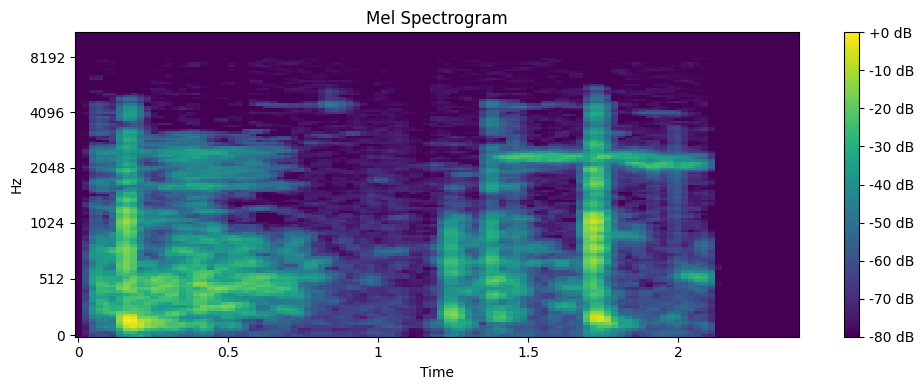

In [109]:
# Mel-spectogram
for x in random_audio:
    file_path = os.path.join(audioFilePath, path)
    audio_file_path = os.path.join('D:/cache', x)
    audio, sr = lbs.load(audio_file_path, sr=None)
    mel_spectrogram = lbs.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    # try:
    #     print(f"For {x} mel-spectogram features:{mel_spectrogram}")

    # except:
    #     break
random_audio1 = df['path'].sample(n=1).values
for x in random_audio1:
    file_path = os.path.join('D:/cache', x)
    audio, sr = lbs.load(audio_file_path)
    plt.figure(figsize=(10, 4))
    mel_spectrogram_db = lbs.power_to_db(mel_spectrogram, ref=np.max)
    lbs.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()

In [97]:
# Chroma features 
for x in random_audio:
    file_path = os.path.join(audioFilePath, path)
    audio_file_path = os.path.join('D:/cache', x)
    audio, sr = lbs.load(audio_file_path, sr=None)
    chroma = lbs.feature.chroma_stft(y=audio, sr=sr)
    try:
        print(f"For {x} chroma features: {chroma}")

    except:
        break
    

For common_voice_uz_30183156.mp3 chroma features: [[0.         0.         0.         ... 0.69952285 0.3834361  0.4514551 ]
 [0.         0.         0.         ... 0.83093053 0.44520447 0.5143469 ]
 [0.         0.         0.         ... 0.9433554  0.40826088 0.39068067]
 ...
 [0.         0.         0.         ... 0.9095537  0.91182655 1.        ]
 [0.         0.         0.         ... 0.9497693  0.62879705 0.8801215 ]
 [0.         0.         0.         ... 0.8277241  0.7487162  0.81055844]]
For common_voice_uz_30045077.mp3 chroma features: [[0.39825925 0.84899414 1.         ... 0.46877086 0.37423342 0.6013016 ]
 [0.45509118 0.46881267 0.50845534 ... 0.59644294 0.46866462 0.7372321 ]
 [0.58568966 0.12001438 0.12228198 ... 0.71155053 0.66996616 0.84632146]
 ...
 [0.57222    0.5716151  0.41636828 ... 0.9267095  0.6461085  0.73321414]
 [0.54954994 0.33657408 0.24130535 ... 0.5838228  0.37690976 0.6162014 ]
 [0.46555454 0.4799235  0.47767824 ... 0.50881857 0.3336487  0.5915018 ]]
For common_v